In [16]:
import os
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset

import numpy as np 
import pickle
import matplotlib.pyplot as plt
import time
import copy

from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/fcn_timeseries')

In [18]:
X = pickle.load(open('../dataset/train/cross_subject_data_5_subjects.pickle', 'rb'))
y = X['train_y']

X = X['train_x'].astype(np.float32)

label_map = {'imagine_both_feet': 0, 'imagine_both_fist': 1, 'imagine_left_fist': 2, 'imagine_right_fist': 3}
y = np.vectorize(label_map.__getitem__)(y)

# Convert data to [n_samples, n_channels] -> [n_samples, seq_len, n_channels]

In [19]:
seq_len = 100
n_channels = 64

def reshape_data(X, y, seq_len):
    print('X original shape:', X.shape)
    print('y original shape:', y.shape)
    len_tail = X.shape[0] % seq_len
    X = X[:-len_tail].reshape(-1, seq_len, n_channels)
    X = np.moveaxis(X, 1, -1)
    y = y[:-len_tail].reshape(-1, seq_len)

    print('X conversion shape:', X.shape)
    print('y conversion shape:', y.shape)
    return X, y[:, -1]

X, y = reshape_data(X, y, seq_len)

X original shape: (295008, 64)
y original shape: (295008,)
X conversion shape: (2950, 64, 100)
y conversion shape: (2950, 100)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)
def print_class_dist(y):
    dist = {}

    labels = np.unique(y)
    for label in labels:
        dist[str(label)] = len(y[y == label]) / len(y)
    print(dist)
print_class_dist(y)
print_class_dist(y_train)
print_class_dist(y_test)

{'0': 0.24745762711864408, '1': 0.25254237288135595, '2': 0.25864406779661014, '3': 0.24135593220338983}
{'0': 0.24745762711864408, '1': 0.25254237288135595, '2': 0.2584745762711864, '3': 0.24152542372881355}
{'0': 0.24745762711864408, '1': 0.25254237288135595, '2': 0.2593220338983051, '3': 0.24067796610169492}


In [21]:
# Normalize
mean, std = X.mean(), X.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [22]:
batch_size = 32
X_train, y_train = torch.tensor(X_train).to(device), torch.tensor(y_train).to(device)
X_test, y_test = torch.tensor(X_test).to(device), torch.tensor(y_test).to(device)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}
dataloaders = {'train': train_loader, 'val': test_loader}
class_names = list(label_map.keys())
print(class_names)

['imagine_both_feet', 'imagine_both_fist', 'imagine_left_fist', 'imagine_right_fist']


In [23]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            writer.add_scalar(f'{phase} loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase} accuracy', epoch_acc, epoch)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

In [24]:
for X, y in dataloaders['val']:
    print(X.shape)
    X_train_flat = torch.flatten(X, 1)
    print(X_train_flat.shape)
    break

torch.Size([32, 64, 100])
torch.Size([32, 6400])


In [25]:
l1 = nn.Linear(100, 128).to(device)
out = l1(X)
out.shape

torch.Size([32, 64, 128])

In [26]:
sequence_length = seq_len
input_size = sequence_length
hidden_size_1 = 1024
hidden_size_2 = 2048
hidden_size_3 = 1024
num_classes = 4
num_epochs = 100
batch_size = 100

class FCN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, num_classes):
        super(FCN, self).__init__()
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.l1 = nn.Linear(input_size, hidden_size_1)
        self.l2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.l3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.l4 = nn.Linear(hidden_size_3*n_channels, num_classes)
        self.flatten = nn.Flatten()
    def forward(self, x):
        out = self.l1(x)
        out = self.relu1(out)
        out = self.l2(out)
        out = self.relu1(out)
        out = self.l3(out)
        out = self.flatten(out)
        out = self.l4(out)
        return out

model = FCN(input_size, hidden_size_1, hidden_size_2, hidden_size_3, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

writer.add_graph(model, X_train)

model = train_model(model, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/99
----------
train Loss: 1.5222 Acc: 0.2513
val Loss: 1.3913 Acc: 0.2475

Epoch 1/99
----------
train Loss: 1.4027 Acc: 0.2695
val Loss: 1.4689 Acc: 0.2475

Epoch 2/99
----------
train Loss: 1.3994 Acc: 0.2623
val Loss: 1.3867 Acc: 0.2593

Epoch 3/99
----------
train Loss: 1.3933 Acc: 0.2458
val Loss: 1.3884 Acc: 0.2593

Epoch 4/99
----------
train Loss: 1.3923 Acc: 0.2369
val Loss: 1.3867 Acc: 0.2492

Epoch 5/99
----------
train Loss: 1.3884 Acc: 0.2424
val Loss: 1.3860 Acc: 0.2627

Epoch 6/99
----------
train Loss: 1.3877 Acc: 0.2377
val Loss: 1.3881 Acc: 0.2492

Epoch 7/99
----------
train Loss: 1.3998 Acc: 0.2619
val Loss: 1.4203 Acc: 0.2407

Epoch 8/99
----------
train Loss: 1.3973 Acc: 0.2513
val Loss: 1.3927 Acc: 0.2407

Epoch 9/99
----------
train Loss: 1.3891 Acc: 0.2466
val Loss: 1.3865 Acc: 0.2475

Epoch 10/99
----------
train Loss: 1.3871 Acc: 0.2597
val Loss: 1.3861 Acc: 0.2593

Epoch 11/99
----------
train Loss: 1.3867 Acc: 0.2585
val Loss: 1.3861 Acc: 0.2593

Ep

In [27]:
_, y_pred = torch.max(model(X_test), 1)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
cr = classification_report(y_test.cpu().numpy(), y_pred.cpu().numpy())
print(cr)

cm = confusion_matrix(y_test.cpu().numpy(), y_pred.cpu().numpy())
print(cm)

y_pred_ohe = np.zeros((y_pred.size(0), num_classes))
for i, j in enumerate(y_pred):
    y_pred_ohe[i, j] = 1

y_test_ohe = np.zeros((y_test.size(0), num_classes))
for i, j in enumerate(y_test):
    y_test_ohe[i, j] = 1
auroc = roc_auc_score(y_test_ohe, y_pred_ohe, multi_class='ovo')
writer.add_scalar('AUROC OvO', auroc)
print('AUROC ovo:', auroc)
auroc = roc_auc_score(y_test_ohe, y_pred_ohe, multi_class='ovr')
writer.add_scalar('AUROC OvR', auroc)
print('AUROC ovr:', auroc)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       146
           1       0.50      0.01      0.03       149
           2       0.26      1.00      0.41       153
           3       0.00      0.00      0.00       142

    accuracy                           0.26       590
   macro avg       0.19      0.25      0.11       590
weighted avg       0.19      0.26      0.11       590

[[  0   1 145   0]
 [  0   2 147   0]
 [  0   0 153   0]
 [  0   1 141   0]]
AUROC ovo: 0.5022551236846824
AUROC ovr: 0.5022551236846824


/home/amar/Desktop/thesis-2022/env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amar/Desktop/thesis-2022/env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amar/Desktop/thesis-2022/env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [29]:
{str(v): k for k, v in label_map.items()}

{'0': 'imagine_both_feet',
 '1': 'imagine_both_fist',
 '2': 'imagine_left_fist',
 '3': 'imagine_right_fist'}

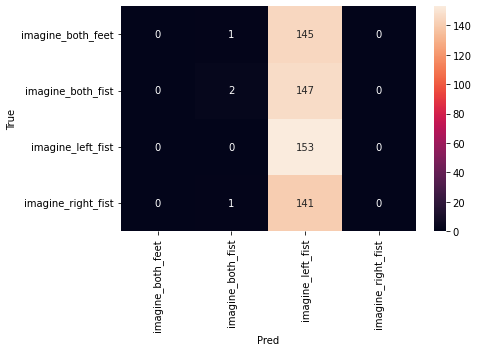

In [30]:
import seaborn as sns
import pandas as pd
import io

figure = plt.figure(figsize=(7, 5))
cm_df = pd.DataFrame(cm, columns=class_names, index=class_names)
sns.heatmap(cm_df, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Pred')
plt.tight_layout()
plt.savefig('runs/fcn/cm.png')
plt.show()

In [31]:
print('Number of trainable parameters')
sum(p.numel() for p in model.parameters() if p.requires_grad)

Number of trainable parameters


4562948